In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
#%matplotlib qt
%matplotlib inline
import collections



In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=5)
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
                
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        

        
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None  
        
        self.iteration=0
        
left=Line()
right=Line()

## UNDISTORT FUNCTION

In [4]:
def undistort(img):
    dist_pickle = pickle.load( open( "../calibration_coefficients/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst


## THRESHOLDED BINARIES  ** check color binary or s_binary to be returned

In [5]:
def to_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255  #seting red channel to zero
    

    return combined_binary,color_binary

## PERSPECTIVE TRANSFORMATION/ UNWARP

In [6]:
def warp(binary):
    img_size = (binary.shape[1], binary.shape[0])
    offset = 100 # offset for dst points
    src = np.float32([[525.744,499.092],[762.396,499.092],[1046.65,682.505],[261.147,682.505]])
    dst = np.float32([[2*offset, offset], [img_size[0]-2*offset, offset], 
                                     [img_size[0]-2*offset, img_size[1]], 
                                     [2*offset, img_size[1]]]) #2*offset= horizantal clearance on either sides
    ##        1               2
    ##
    ##
    ##        4               3  ## represent order of coordinates in the arguments
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(binary, M, img_size)

    
    return warped, M, Minv


In [7]:
def unwarp(binary,Minv):
    img_size = (binary.shape[1], binary.shape[0])
    unwarped = cv2.warpPerspective(binary, Minv, img_size)
    print("success!")
    return unwarped
    

## HISTOGRAM

In [8]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)

    return histogram

## SLIDING WINDOW

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



In [29]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(ploty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.figure()

    ## from function search_around_poly
    ##https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/626f183c-593e-41d7-a828-eda3c6122573/concepts/474a329a-78d0-4a33-833a-34d02a35fc13
    
    window_img = np.zeros_like(out_img)
    margin=100
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #print('####',left_line_pts)
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
   
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   
   
    plt.title("Lanes Detected using Sliding Window", fontsize=30)
    plt.imshow(result)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    
    return out_img,ploty,left_fit,right_fit




## BLINDSEARCH

In [11]:
def blindsearch(binary_warped,ploty,left_fit,right_fit):
   
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # HYPERPARAMETERS
 
    # Set the width of the windows +/- margin
    margin = 100

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #print("Shape of left_x is ", type(left_x), "nonzerox is ", nonzeroy, "win_xleft_low is ",win_xleft_low )
    
    left_lane_inds = []
    right_lane_inds = []
    for i in range(binary_warped.shape[0]):
        #print(i)
        win_y_low = i-1
        win_y_high = i
        win_xleft_low =  left_x[i]- margin
        win_xleft_high = left_x[i] + margin
        win_xright_low = right_x[i] - margin
        win_xright_high = right_x[i] + margin    
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy <= win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy <= win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    


    left_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure()
    plt.title("Lanes Detected using blind search", fontsize=30)
    plt.imshow(out_img)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_x, ploty, color='yellow')
    plt.plot(right_x, ploty, color='yellow')
    return 

######################################

##DELETE THIS IF BLINSSEARCH@2 works

In [12]:
def blindsearch2(binary_warped,ploty,left_fit,right_fit):
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_img = np.zeros_like(out_img)
    margin=100

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]),(255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]),(0,0, 255))
    result = cv2.bitwise_and(out_img, window_img,  mask=None)
    
    nonzero_left = result[:,:,0].nonzero()
    nonzero_right = result[:,:,2].nonzero()
    
    left_fit_new = np.polyfit(np.array(nonzero_left[0]),np.array(nonzero_left[1]), 2)
    right_fit_new = np.polyfit(np.array(nonzero_right[0]),np.array(nonzero_right[1]), 2)
    
    left_x = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_x = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    plt.figure()
    plt.title("Lanes Detected using blind search 2", fontsize=30)
    plt.imshow(result)
    
    plt.plot(left_x, ploty, color='yellow')
    plt.plot(right_x, ploty, color='yellow')
    return left_fit_new,right_fit_new


In [13]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad




In [82]:
def fit_polynomial_real(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #print(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/210 #30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 #3.7/700 # meters per pixel in x dimension        
    
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    
    return ploty,left_fit,right_fit



In [83]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/210 #30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 #3.7/700 # meters per pixel in x dimension        
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty )
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad




In [16]:
def plot_roi(binary,ploty,left_fit,right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    left_fitx = (left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    right_fitx = (right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    
    return out_img

# PIPELINE FOR IMAGES ** change from single image to all images

## READ AND CLEAN AN IMAGE

left_curverad,right_curverad in pixels= 8231.641741821273 3583.6590861697346
left_curverad,right_curverad= 450.4685282224871 190.8569201868925
success!


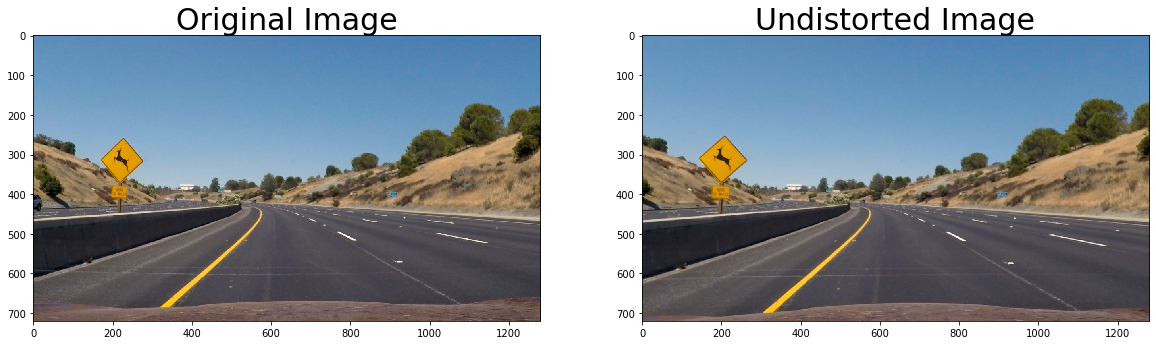

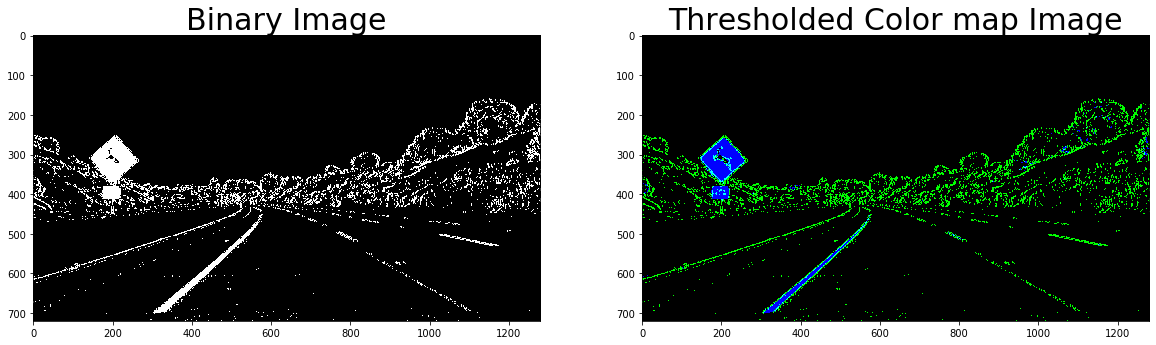

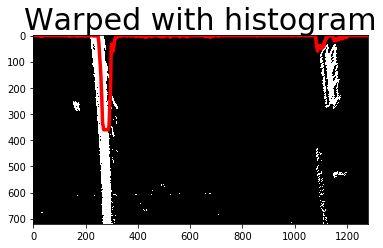

<Figure size 432x288 with 0 Axes>

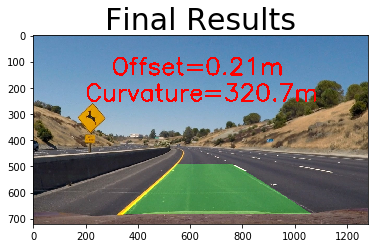

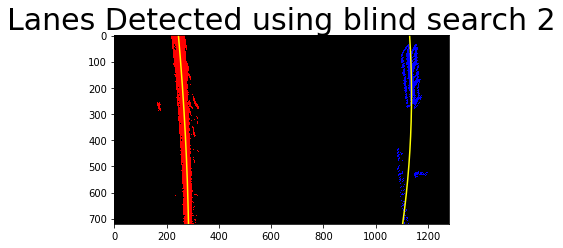

In [20]:
import glob
images = glob.glob("../test_images/test2*.jpg")


import matplotlib.image as mpimg
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    undst=undistort(img)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undst)
    ax2.set_title('Undistorted Image', fontsize=30)

    binary,color_binary=to_binary(undst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(binary,cmap='gray')
    ax1.set_title('Binary Image', fontsize=30)
    ax2.imshow(color_binary)
    ax2.set_title('Thresholded Color map Image', fontsize=30)
    

    binary_warped, M, Minv=warp(binary)
    plt.figure()
    plt.imshow(binary_warped,cmap='gray')
    histogram = hist(binary_warped)  # This is only for visulaization
    plt.plot(histogram,'r', linewidth=3.5)
    plt.title("Warped with histogram", fontsize=30)

    out_img,ploty,left_fit,right_fit = fit_polynomial(binary_warped)
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    print('left_curverad,right_curverad in pixels=',left_curverad,right_curverad)
    
        ## To get real world curvature
    ploty_real,left_fit_real,right_fit_real=fit_polynomial_real(binary_warped)
    left_curverad, right_curverad=measure_curvature_real(ploty_real, left_fit_real, right_fit_real)
    print('left_curverad,right_curverad=',left_curverad,right_curverad)
    
    image_center=img.shape[1]//2
    lane_center=(left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]+
    right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2])//2

    offset=np.abs(image_center-lane_center)*3.7/900
    
    roi=plot_roi(binary,ploty,left_fit,right_fit)
    roi_unwarped=unwarp(roi,Minv)
    
    string1=("Offset="+ "{:.2f}".format(offset)+'m')
    string2=("Curvature="+ "{:.1f}".format((left_curverad+ right_curverad)/2)+'m')
    #string2=("L.Curvature="+ "{:.1f}".format(left_curverad)+'m')
    #string3=("R.Curvature="+ "{:.1f}".format( right_curverad)+'m')
   
   
    result = cv2.addWeighted(img, 1, roi_unwarped, 0.3, 0)
    cv2.putText(result, string1,(300,150),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    cv2.putText(result, string2,(200,250),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    #cv2.putText(result, string3,(200,350),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    #cv2.putText(result, np.average(left_curverad,right_curverad))
    plt.figure()
    plt.imshow(result)
    plt.title("Final Results", fontsize=30)
    
    
    left_fit_new,right_fit_new=blindsearch2(binary_warped,ploty,left_fit,right_fit)
    

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [90]:
def process_blind_search(binary_warped,ploty,left.current_fit,right.current_fit):
    left_fit,right_fit=blindsearch2(binary_warped,ploty,left.current_fit,right.current_fit)
    
    

SyntaxError: invalid syntax (<ipython-input-90-860d20d7c2e8>, line 1)

In [87]:
def process_image(img):
    
    left.iteration+=1
    undst=undistort(img)
    binary,color_binary=to_binary(undst)
    binary_warped, M, Minv=warp(binary)
    
    if left.detected==True and right.detected==True:
        process_blind_search(binary_warped,ploty,left.current_fit,right.current_fit)
    
    
    out_img,ploty,left_fit,right_fit = fit_polynomial(binary_warped)
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)
    
    
    ploty_real,left_fit_real,right_fit_real=fit_polynomial_real(binary_warped)
    left_curverad, right_curverad=measure_curvature_real(ploty_real, left_fit_real, right_fit_real)
    print('Real world left_curverad,right_curverad=',left_curverad,right_curverad)
    print("Percentage change:",abs(right_curverad-left_curverad)/min(left_curverad,right_curverad)*100)
    
    
    image_center=img.shape[1]//2
    lane_center=(left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]+
    right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2])//2
    
    lane_width=abs((left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2])-
    (right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]))*3.7/900
    
    
    offset=np.abs(image_center-lane_center)*3.7/800
    
    print("lane width:",lane_width)
    
    
    
    ###CLASS ASSIGNMENTS
    left.recent_xfitted.append(left_fit)
    right.recent_xfitted.append(right_fit)
    
   
    
    
    
    roi=plot_roi(binary,ploty,left_fit,right_fit)
    roi_unwarped=unwarp(roi,Minv)
    
    string1=("Offset="+ "{:.2f}".format(offset)+'m')
    string2=("Curvature="+ "{:.1f}".format((left_curverad+ right_curverad)/2)+'m')
    #string2=("L.Curvature="+ "{:.1f}".format(left_curverad)+'m')
    #string3=("R.Curvature="+ "{:.1f}".format( right_curverad)+'m')
   
   
    result = cv2.addWeighted(img, 1, roi_unwarped, 0.3, 0)
    cv2.putText(result, string1,(300,150),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    cv2.putText(result, string2,(200,250),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0) ,7 )
    return result


Real world left_curverad,right_curverad= 2101.527868258843 303.6155827658846
Percentage change: 592.1673285390339
lane width: 3.619008013083526
success!
Moviepy - Building video ../output_Videos/project_video_output.mp4.
Moviepy - Writing video ../output_Videos/project_video_output.mp4



t:   0%|                                                                              | 0/63 [00:00<?, ?it/s, now=None]

Real world left_curverad,right_curverad= 2101.527868258843 303.6155827658846
Percentage change: 592.1673285390339
lane width: 3.619008013083526
success!


t:   3%|██▏                                                                   | 2/63 [00:00<00:09,  6.30it/s, now=None]

Real world left_curverad,right_curverad= 2783.9601048664513 404.3545443807803
Percentage change: 588.4948230592405
lane width: 3.644334740168608
success!


t:   5%|███▎                                                                  | 3/63 [00:00<00:12,  4.68it/s, now=None]

Real world left_curverad,right_curverad= 3015.240627244446 641.6306735451136
Percentage change: 369.93399031015025
lane width: 3.6949601540758357
success!


t:   6%|████▍                                                                 | 4/63 [00:00<00:14,  4.15it/s, now=None]

Real world left_curverad,right_curverad= 618.3267016279988 397.5825356845508
Percentage change: 55.52159517353408
lane width: 3.715924260615148
success!


t:   8%|█████▌                                                                | 5/63 [00:01<00:15,  3.80it/s, now=None]

Real world left_curverad,right_curverad= 23953.715944605778 212.10639429360128
Percentage change: 11193.254983840156
lane width: 3.691036786601947
success!


t:  10%|██████▋                                                               | 6/63 [00:01<00:15,  3.64it/s, now=None]

Real world left_curverad,right_curverad= 814.745862736948 498.41898940350376
Percentage change: 63.46605567978396
lane width: 3.707988135499023
success!


t:  11%|███████▊                                                              | 7/63 [00:01<00:15,  3.51it/s, now=None]

Real world left_curverad,right_curverad= 431.18225121343943 655.5691200243956
Percentage change: 52.039913094633036
lane width: 3.697862648829703
success!


t:  13%|████████▉                                                             | 8/63 [00:02<00:16,  3.34it/s, now=None]

Real world left_curverad,right_curverad= 354.55914499476927 341.6539215522479
Percentage change: 3.7772794715449627
lane width: 3.688235274852377
success!


t:  14%|██████████                                                            | 9/63 [00:02<00:16,  3.29it/s, now=None]

Real world left_curverad,right_curverad= 289.25029620240457 29680.173786062634
Percentage change: 10161.069452905162
lane width: 3.7240436765832117
success!


t:  16%|██████████▉                                                          | 10/63 [00:02<00:16,  3.27it/s, now=None]

Real world left_curverad,right_curverad= 313.36517866524383 920.6821234363498
Percentage change: 193.80485967136752
lane width: 3.674505772986904
success!


t:  17%|████████████                                                         | 11/63 [00:03<00:16,  3.25it/s, now=None]

Real world left_curverad,right_curverad= 371.6334923002234 304.19550205899463
Percentage change: 22.169292374398772
lane width: 3.648952893002537
success!


t:  19%|█████████████▏                                                       | 12/63 [00:03<00:15,  3.25it/s, now=None]

Real world left_curverad,right_curverad= 364.46894328798714 249.96168854031052
Percentage change: 45.80992207900309
lane width: 3.6364690123644854
success!


t:  21%|██████████████▏                                                      | 13/63 [00:03<00:15,  3.25it/s, now=None]

Real world left_curverad,right_curverad= 401.5850515811643 167.00912346172694
Percentage change: 140.456954241302
lane width: 3.570682061360769
success!


t:  22%|███████████████▎                                                     | 14/63 [00:04<00:14,  3.27it/s, now=None]

Real world left_curverad,right_curverad= 359.21805714071735 551.0931666681832
Percentage change: 53.414661572066294
lane width: 3.644341686709012
success!


t:  24%|████████████████▍                                                    | 15/63 [00:04<00:14,  3.24it/s, now=None]

Real world left_curverad,right_curverad= 360.5325339495809 820.0252458081102
Percentage change: 127.44833505727047
lane width: 3.6478682140561958
success!


t:  25%|█████████████████▌                                                   | 16/63 [00:04<00:14,  3.25it/s, now=None]

Real world left_curverad,right_curverad= 248.948196072695 351.7915783057222
Percentage change: 41.31115784546439
lane width: 3.660633793422999
success!


t:  27%|██████████████████▌                                                  | 17/63 [00:05<00:14,  3.10it/s, now=None]

Real world left_curverad,right_curverad= 412.7488467883278 198.25251243529164
Percentage change: 108.19350116586615
lane width: 3.6288304880860642
success!


t:  29%|███████████████████▋                                                 | 18/63 [00:05<00:14,  3.18it/s, now=None]

Real world left_curverad,right_curverad= 344.3905955215552 426.45850510982723
Percentage change: 23.8298927599884
lane width: 3.6475002997230317
success!


t:  30%|████████████████████▊                                                | 19/63 [00:05<00:14,  3.07it/s, now=None]

Real world left_curverad,right_curverad= 287.5622866953327 491.57217275730363
Percentage change: 70.94459026823495
lane width: 3.6558885947497703
success!


t:  32%|█████████████████████▉                                               | 20/63 [00:06<00:14,  3.06it/s, now=None]

Real world left_curverad,right_curverad= 266.01514382906805 511.86502104319027
Percentage change: 92.41950427156759
lane width: 3.6570370280753535
success!


t:  33%|███████████████████████                                              | 21/63 [00:06<00:13,  3.10it/s, now=None]

Real world left_curverad,right_curverad= 239.03259830643748 432.5660654517474
Percentage change: 80.96530285681031
lane width: 3.622322525599999
success!


t:  35%|████████████████████████                                             | 22/63 [00:06<00:13,  3.14it/s, now=None]

Real world left_curverad,right_curverad= 223.01106657004217 466.2069552948211
Percentage change: 109.05104058968178
lane width: 3.6142934179866506
success!


t:  37%|█████████████████████████▏                                           | 23/63 [00:06<00:12,  3.21it/s, now=None]

Real world left_curverad,right_curverad= 208.32697914955622 337.55482604677644
Percentage change: 62.031258469143644
lane width: 3.6136635926328537
success!


t:  38%|██████████████████████████▎                                          | 24/63 [00:07<00:11,  3.33it/s, now=None]

Real world left_curverad,right_curverad= 240.326048313203 457.1766188525478
Percentage change: 90.23182133662682
lane width: 3.6401084118857794
success!


t:  40%|███████████████████████████▍                                         | 25/63 [00:07<00:11,  3.29it/s, now=None]

Real world left_curverad,right_curverad= 254.2074523378247 311.5435092277731
Percentage change: 22.55482927925835
lane width: 3.628285524545014
success!


t:  41%|████████████████████████████▍                                        | 26/63 [00:07<00:11,  3.28it/s, now=None]

Real world left_curverad,right_curverad= 278.19674420884195 161.09037743019698
Percentage change: 72.69606580280626
lane width: 3.573119611325659
success!


t:  43%|█████████████████████████████▌                                       | 27/63 [00:08<00:10,  3.28it/s, now=None]

Real world left_curverad,right_curverad= 284.12361256064196 239.1451737836761
Percentage change: 18.80800605980535
lane width: 3.6046341589242297
success!


t:  44%|██████████████████████████████▋                                      | 28/63 [00:08<00:11,  3.13it/s, now=None]

Real world left_curverad,right_curverad= 263.89324343403615 358.91114110717535
Percentage change: 36.00618812239135
lane width: 3.623178027270895
success!


t:  46%|███████████████████████████████▊                                     | 29/63 [00:08<00:10,  3.12it/s, now=None]

Real world left_curverad,right_curverad= 206.8942216724769 269.7624577527892
Percentage change: 30.386656317466237
lane width: 3.6425542068411763
success!


t:  48%|████████████████████████████████▊                                    | 30/63 [00:09<00:10,  3.04it/s, now=None]

Real world left_curverad,right_curverad= 351.13542303678895 226.89914944728375
Percentage change: 54.75396178969346
lane width: 3.6259492728888016
success!


t:  49%|█████████████████████████████████▉                                   | 31/63 [00:09<00:10,  2.99it/s, now=None]

Real world left_curverad,right_curverad= 297.9751230630396 523.2869699250267
Percentage change: 75.61431455951448
lane width: 3.6444033637693476
success!


t:  51%|███████████████████████████████████                                  | 32/63 [00:09<00:10,  3.05it/s, now=None]

Real world left_curverad,right_curverad= 280.06964090541794 852.6487447762964
Percentage change: 204.44168886703565
lane width: 3.6474536084586826
success!


t:  52%|████████████████████████████████████▏                                | 33/63 [00:10<00:09,  3.14it/s, now=None]

Real world left_curverad,right_curverad= 309.03303070201326 333.01917612411347
Percentage change: 7.761676920946672
lane width: 3.6069869894389215
success!


t:  54%|█████████████████████████████████████▏                               | 34/63 [00:10<00:09,  3.19it/s, now=None]

Real world left_curverad,right_curverad= 332.7574152218515 477.47721676521377
Percentage change: 43.49108236908159
lane width: 3.5842600236549296
success!


t:  56%|██████████████████████████████████████▎                              | 35/63 [00:10<00:08,  3.13it/s, now=None]

Real world left_curverad,right_curverad= 456.5618409846598 1859.8173666852304
Percentage change: 307.3527832887197
lane width: 3.6126502295921825
success!


t:  57%|███████████████████████████████████████▍                             | 36/63 [00:11<00:08,  3.17it/s, now=None]

Real world left_curverad,right_curverad= 700.385929830506 836.0759135135478
Percentage change: 19.373602167576216
lane width: 3.5888110116100376
success!


t:  59%|████████████████████████████████████████▌                            | 37/63 [00:11<00:08,  3.21it/s, now=None]

Real world left_curverad,right_curverad= 1100.9977401879573 265.88703901579936
Percentage change: 314.08477233917915
lane width: 3.5670922091341417
success!


t:  60%|█████████████████████████████████████████▌                           | 38/63 [00:11<00:07,  3.26it/s, now=None]

Real world left_curverad,right_curverad= 1639.5022561540043 341.25062602240104
Percentage change: 380.4393402186406
lane width: 3.5610355974107293
success!


t:  62%|██████████████████████████████████████████▋                          | 39/63 [00:11<00:07,  3.25it/s, now=None]

Real world left_curverad,right_curverad= 24825.88339973419 460.55287372811887
Percentage change: 5290.4523923109455
lane width: 3.5752560531972915
success!


t:  63%|███████████████████████████████████████████▊                         | 40/63 [00:12<00:07,  3.28it/s, now=None]

Real world left_curverad,right_curverad= 158408.62098373644 478.85960717193205
Percentage change: 32980.38903495584
lane width: 3.591932448542124
success!


t:  65%|████████████████████████████████████████████▉                        | 41/63 [00:12<00:06,  3.18it/s, now=None]

Real world left_curverad,right_curverad= 815.5254504572522 218.5384733301914
Percentage change: 273.1724844737378
lane width: 3.6089263276633217
success!


t:  67%|██████████████████████████████████████████████                       | 42/63 [00:12<00:06,  3.18it/s, now=None]

Real world left_curverad,right_curverad= 855.4014268335935 204.8229156303815
Percentage change: 317.62974821490695
lane width: 3.613802960568991
success!


t:  68%|███████████████████████████████████████████████                      | 43/63 [00:13<00:06,  3.12it/s, now=None]

Real world left_curverad,right_curverad= 685.638299434399 415.00180920299323
Percentage change: 65.21332780480171
lane width: 3.627305964561269
success!


t:  70%|████████████████████████████████████████████████▏                    | 44/63 [00:16<00:24,  1.31s/it, now=None]

Real world left_curverad,right_curverad= 582.6314007035124 497.17134815382053
Percentage change: 17.189255347685744
lane width: 3.6216780826961563
success!


t:  71%|█████████████████████████████████████████████████▎                   | 45/63 [00:17<00:18,  1.02s/it, now=None]

Real world left_curverad,right_curverad= 386.4647528937029 4267.424188675073
Percentage change: 1004.2208006609151
lane width: 3.6454006248836346
success!


t:  73%|██████████████████████████████████████████████████▍                  | 46/63 [00:17<00:13,  1.23it/s, now=None]

Real world left_curverad,right_curverad= 311.04326662201197 260.15406242752374
Percentage change: 19.561179909948724
lane width: 3.715227682410276
success!


t:  75%|███████████████████████████████████████████████████▍                 | 47/63 [00:17<00:11,  1.45it/s, now=None]

Real world left_curverad,right_curverad= 293.1431327724965 321.8369919559446
Percentage change: 9.788344319058961
lane width: 3.674074546100781
success!


t:  76%|████████████████████████████████████████████████████▌                | 48/63 [00:18<00:08,  1.72it/s, now=None]

Real world left_curverad,right_curverad= 282.94521173631296 521.9167451705135
Percentage change: 84.45858898538525
lane width: 3.6417381086918885
success!


t:  78%|█████████████████████████████████████████████████████▋               | 49/63 [00:18<00:07,  1.95it/s, now=None]

Real world left_curverad,right_curverad= 285.76524984870105 296.4356837345501
Percentage change: 3.733985812305211
lane width: 3.6311876744770526
success!


t:  79%|██████████████████████████████████████████████████████▊              | 50/63 [00:18<00:05,  2.18it/s, now=None]

Real world left_curverad,right_curverad= 250.33267339503954 267.11723119501426
Percentage change: 6.704900951338347
lane width: 3.58188859885481
success!


t:  81%|███████████████████████████████████████████████████████▊             | 51/63 [00:19<00:05,  2.40it/s, now=None]

Real world left_curverad,right_curverad= 267.9111984854438 527.340005707588
Percentage change: 96.83387954245579
lane width: 3.580245970899612
success!


t:  83%|████████████████████████████████████████████████████████▉            | 52/63 [00:19<00:04,  2.56it/s, now=None]

Real world left_curverad,right_curverad= 302.6035663513406 381.44623295315887
Percentage change: 26.054771116040747
lane width: 3.5889120555219303
success!


t:  84%|██████████████████████████████████████████████████████████           | 53/63 [00:19<00:03,  2.60it/s, now=None]

Real world left_curverad,right_curverad= 378.8655035412929 417.03846205642174
Percentage change: 10.07559626261099
lane width: 3.605271251806567
success!


t:  86%|███████████████████████████████████████████████████████████▏         | 54/63 [00:20<00:03,  2.67it/s, now=None]

Real world left_curverad,right_curverad= 316.5958548403249 417.82094978862347
Percentage change: 31.972969134214175
lane width: 3.6434282283176387
success!


t:  87%|████████████████████████████████████████████████████████████▏        | 55/63 [00:20<00:03,  2.64it/s, now=None]

Real world left_curverad,right_curverad= 570.5271164708574 182.06880708360902
Percentage change: 213.35796922581136
lane width: 3.614560577968859
success!


t:  89%|█████████████████████████████████████████████████████████████▎       | 56/63 [00:21<00:02,  2.71it/s, now=None]

Real world left_curverad,right_curverad= 10516.698427434643 518.4994202061316
Percentage change: 1928.2951181032538
lane width: 3.621302100858958
success!


t:  90%|██████████████████████████████████████████████████████████████▍      | 57/63 [00:21<00:02,  2.79it/s, now=None]

Real world left_curverad,right_curverad= 31910.05481769051 780.8143416017884
Percentage change: 3986.76597207848
lane width: 3.634159685908241
success!


t:  92%|███████████████████████████████████████████████████████████████▌     | 58/63 [00:21<00:01,  2.84it/s, now=None]

Real world left_curverad,right_curverad= 85558.89157955431 1079.4104936629656
Percentage change: 7826.446155735556
lane width: 3.6594118232924973
success!


t:  94%|████████████████████████████████████████████████████████████████▌    | 59/63 [00:22<00:01,  2.95it/s, now=None]

Real world left_curverad,right_curverad= 5403.4194685866905 420.72555241293054
Percentage change: 1184.3097923568434
lane width: 3.6717183777250813
success!


t:  95%|█████████████████████████████████████████████████████████████████▋   | 60/63 [00:22<00:00,  3.00it/s, now=None]

Real world left_curverad,right_curverad= 2452.8088565414646 1073.427583194637
Percentage change: 128.5024993713725
lane width: 3.710090233026295
success!


t:  97%|██████████████████████████████████████████████████████████████████▊  | 61/63 [00:22<00:00,  2.97it/s, now=None]

Real world left_curverad,right_curverad= 666.1920653383279 2732.202383484853
Percentage change: 310.12232442265645
lane width: 3.7147316662317382
success!


t:  98%|███████████████████████████████████████████████████████████████████▉ | 62/63 [00:23<00:00,  3.02it/s, now=None]

Real world left_curverad,right_curverad= 1249.052492389476 606.291717676924
Percentage change: 106.01510064748423
lane width: 3.67818656590319
success!


t: 100%|█████████████████████████████████████████████████████████████████████| 63/63 [00:23<00:00,  3.04it/s, now=None]

Real world left_curverad,right_curverad= 4261.560699326196 216.1724223627425
Percentage change: 1871.371117901059
lane width: 3.633519761722379
success!


Moviepy - Done !
Moviepy - video ready ../output_Videos/project_video_output.mp4
Wall time: 27.1 s


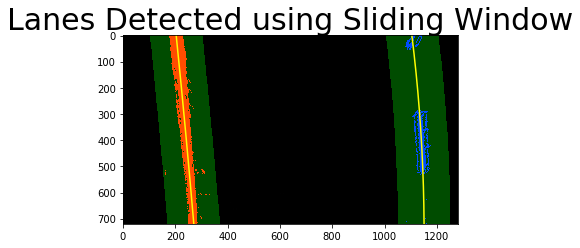

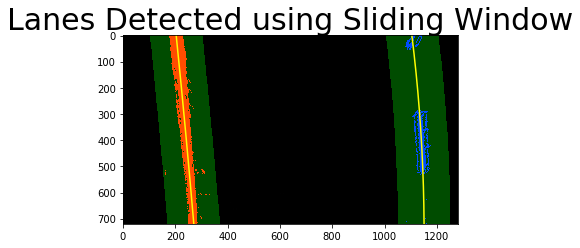

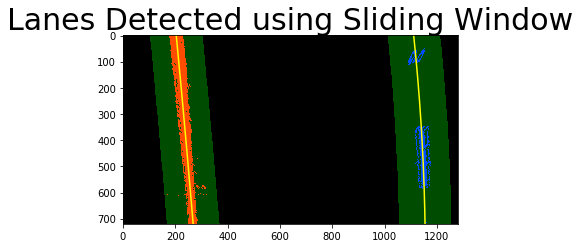

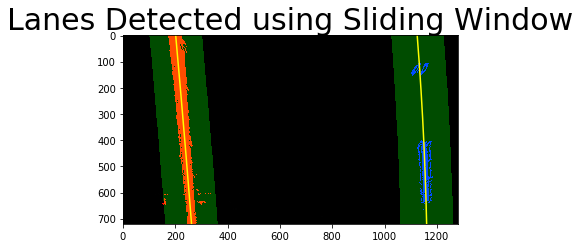

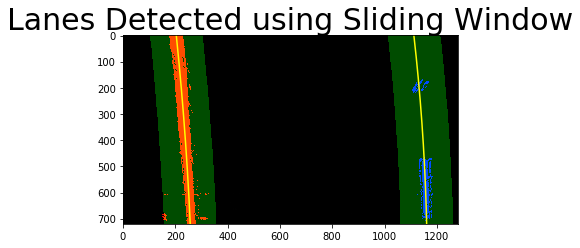

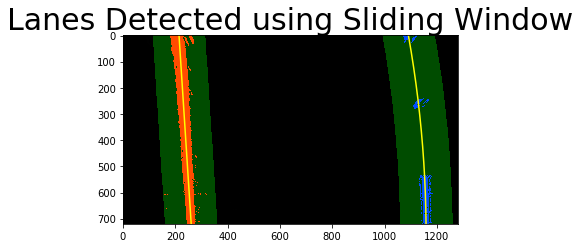

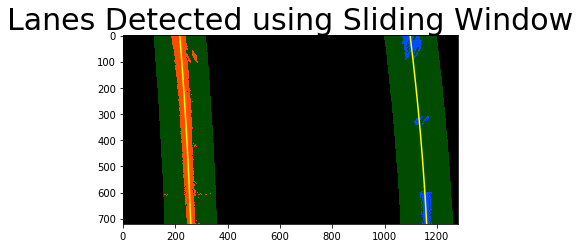

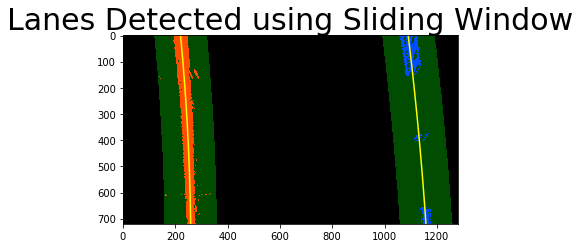

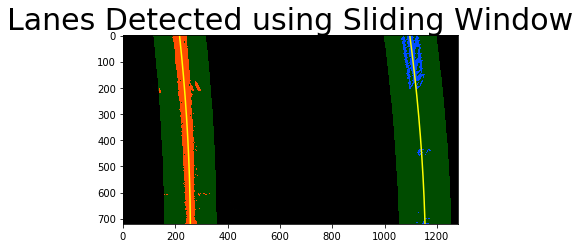

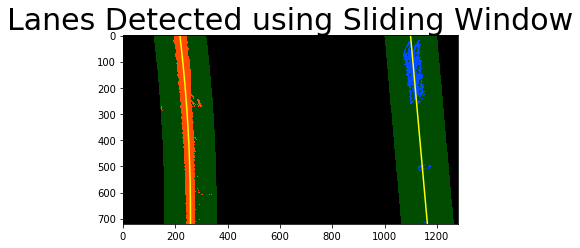

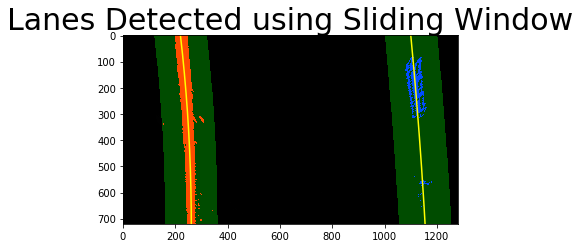

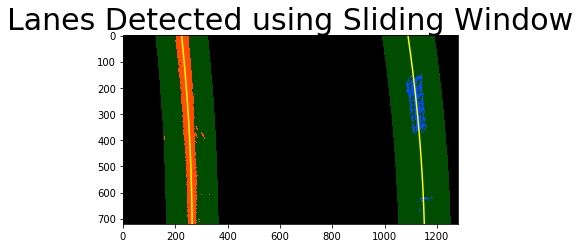

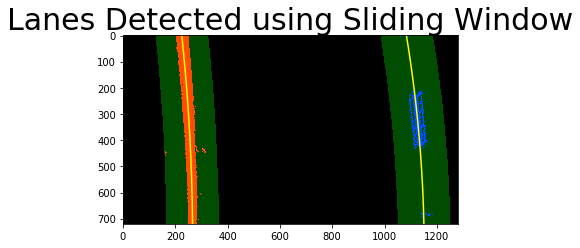

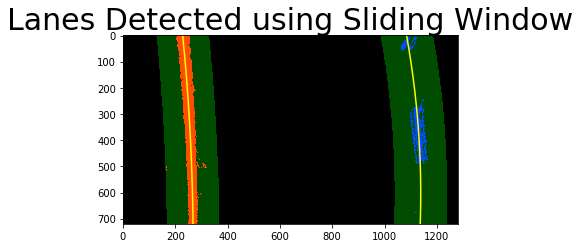

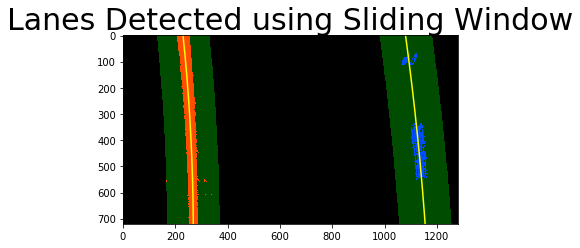

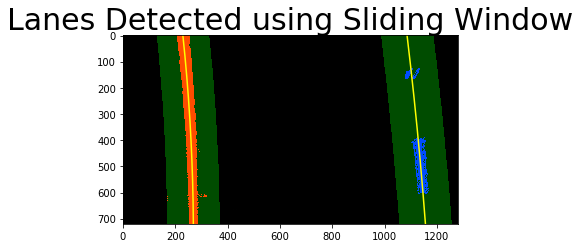

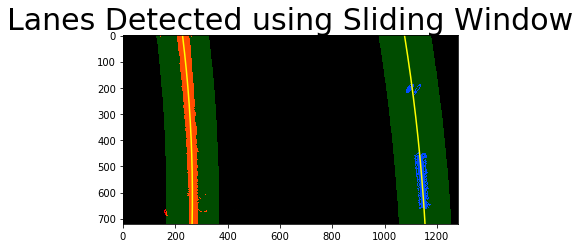

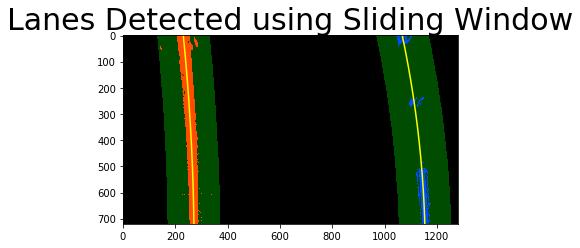

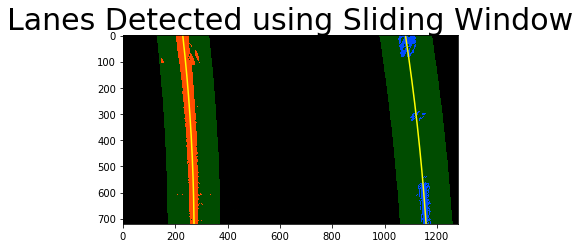

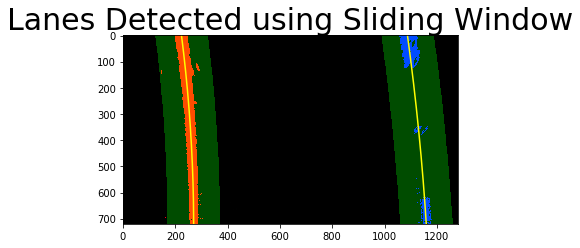

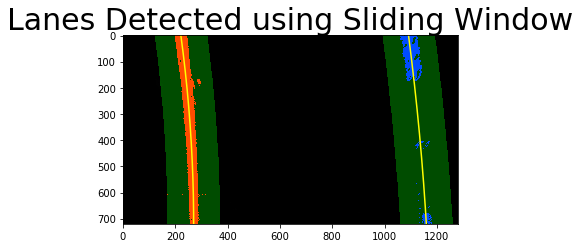

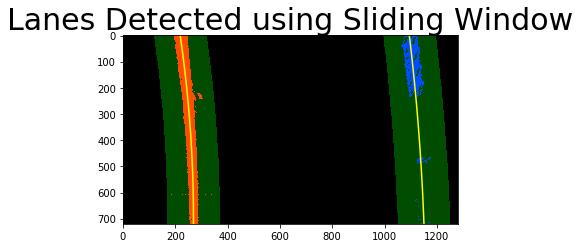

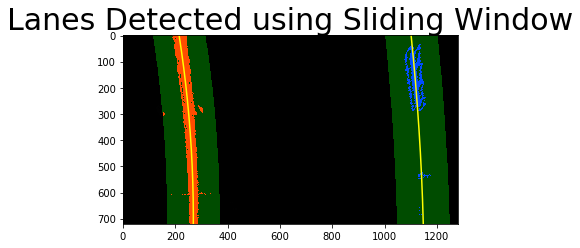

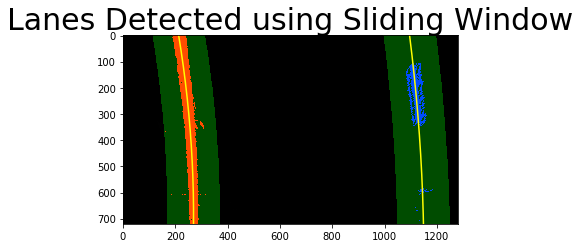

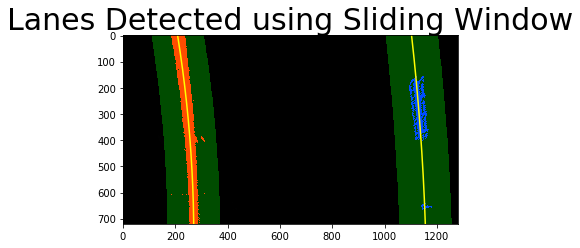

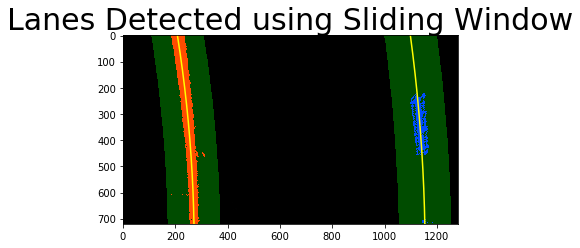

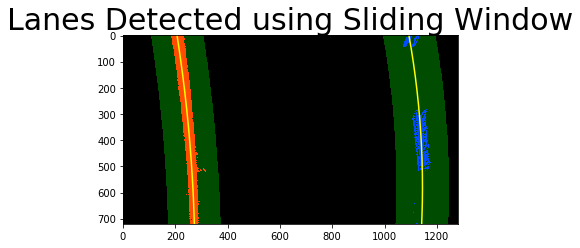

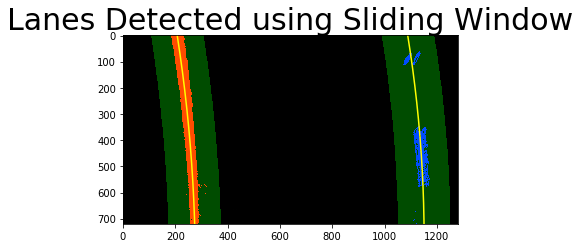

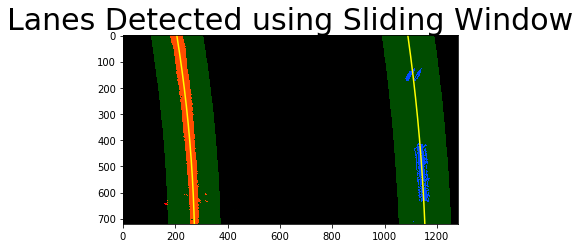

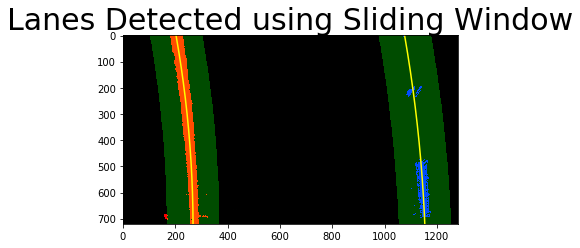

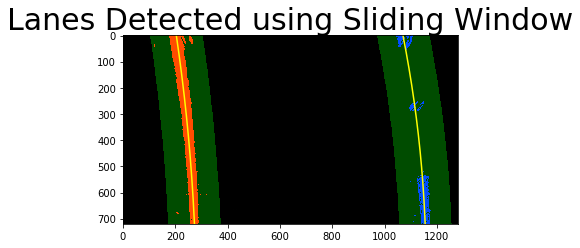

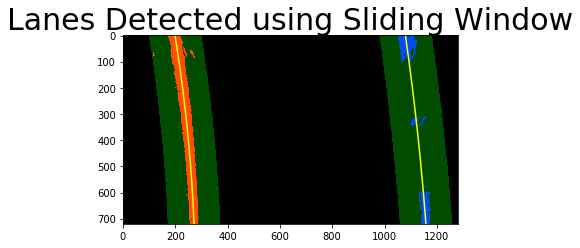

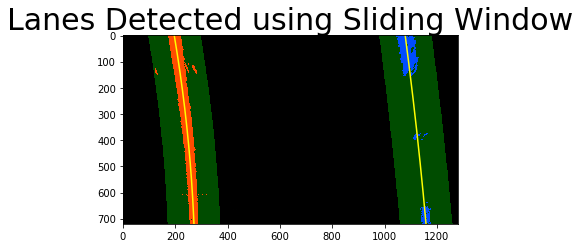

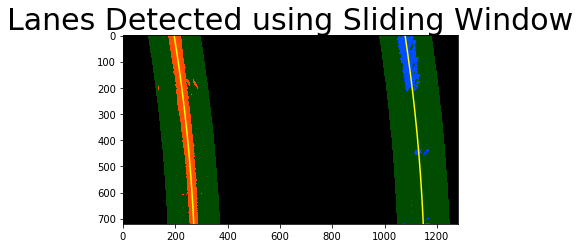

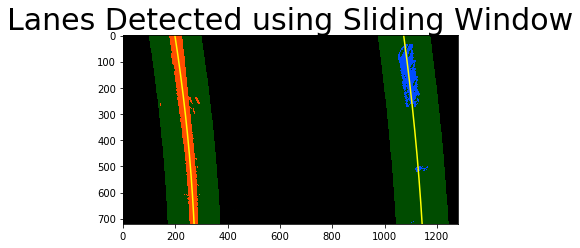

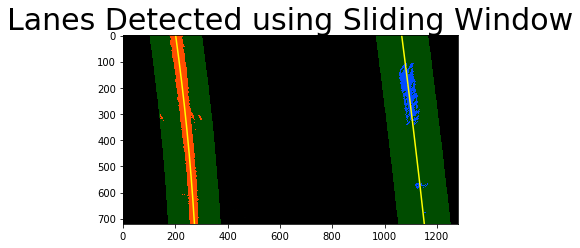

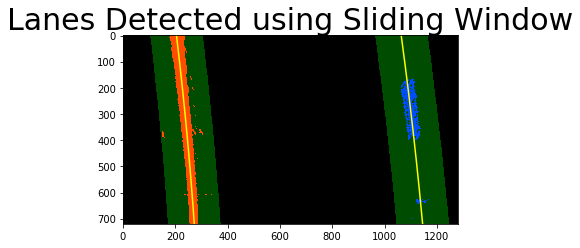

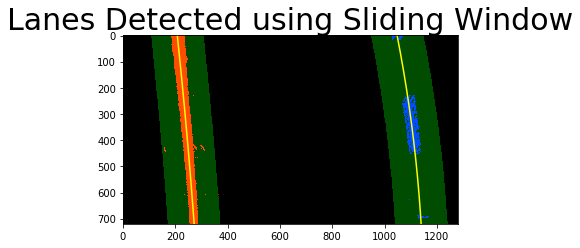

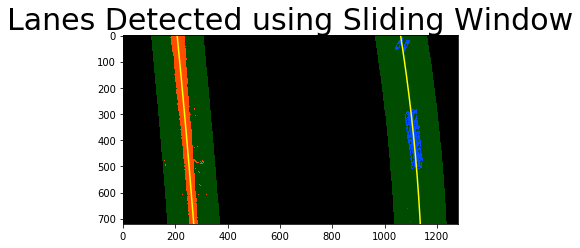

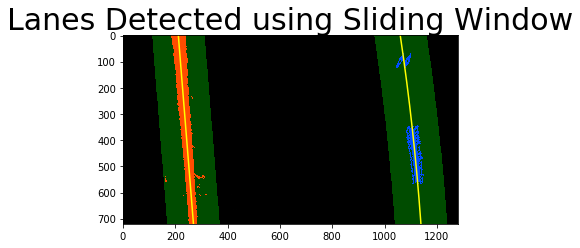

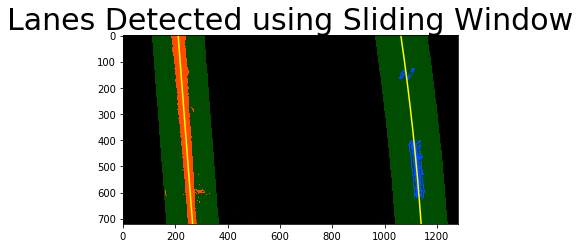

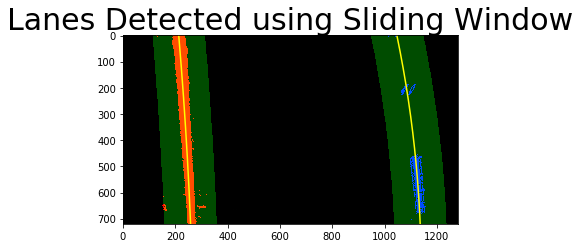

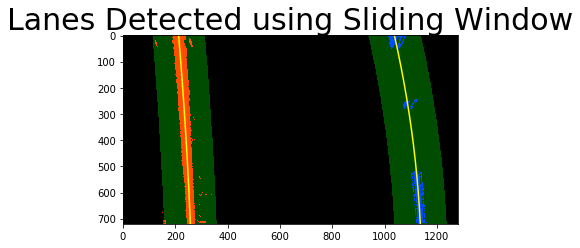

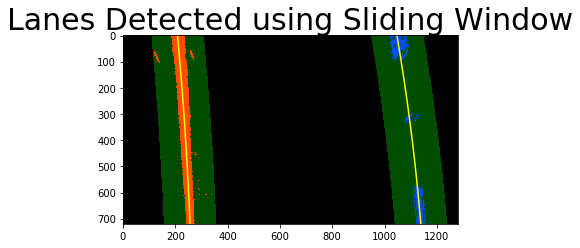

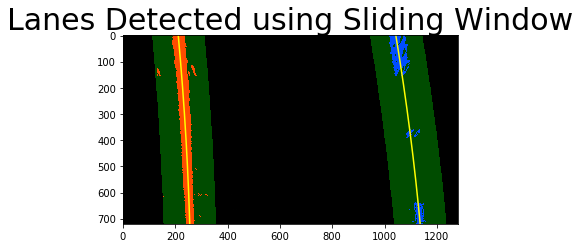

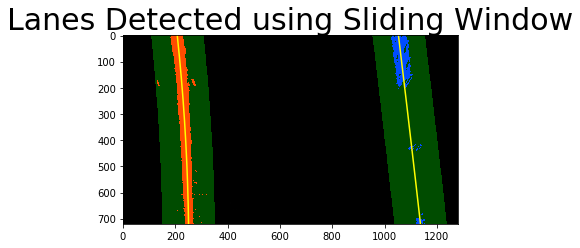

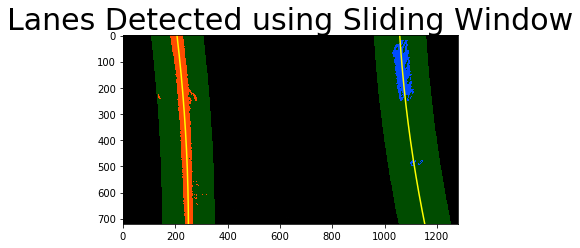

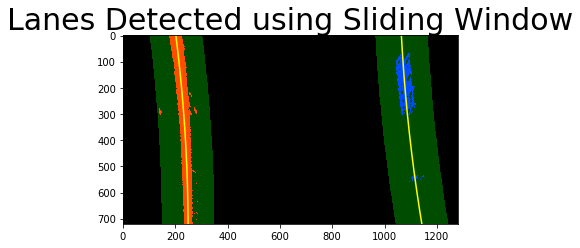

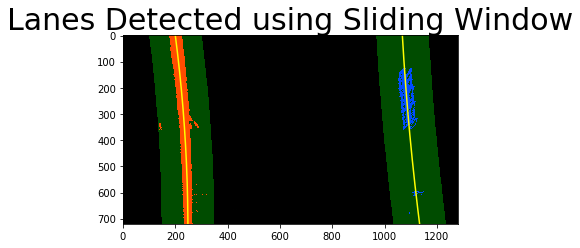

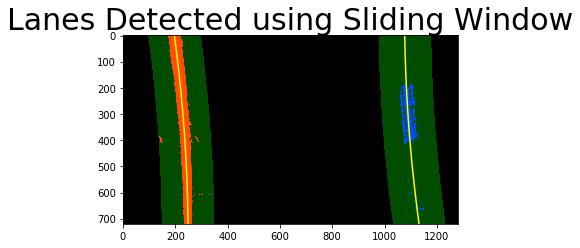

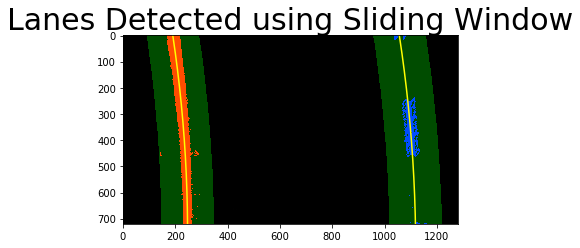

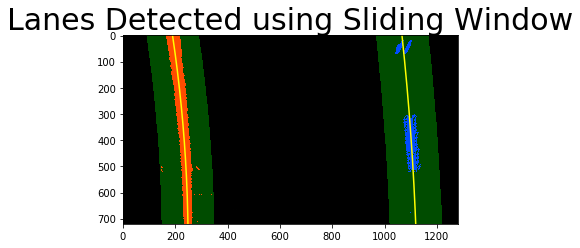

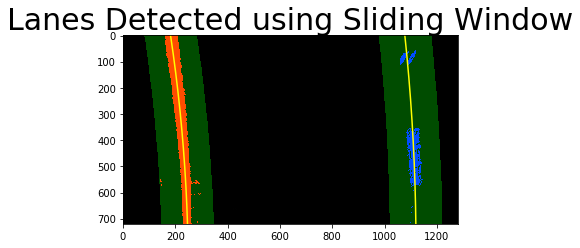

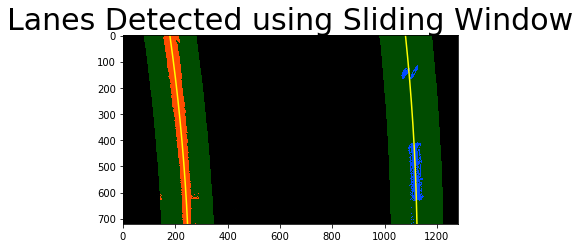

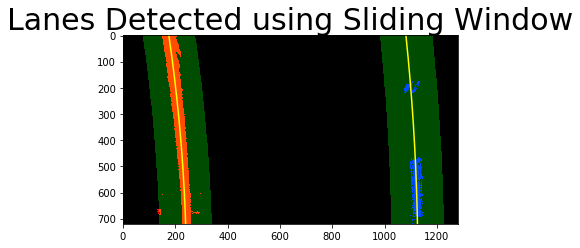

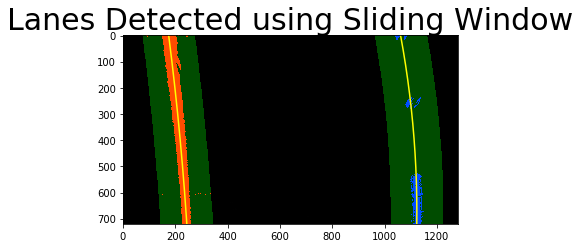

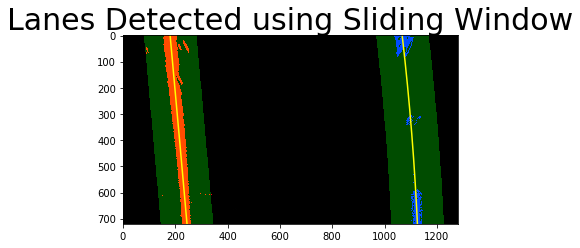

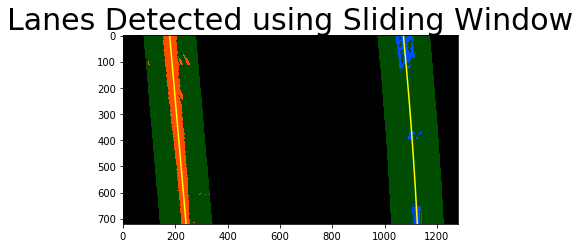

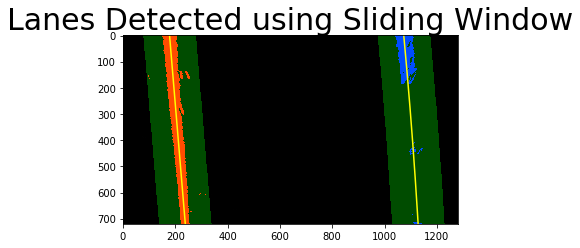

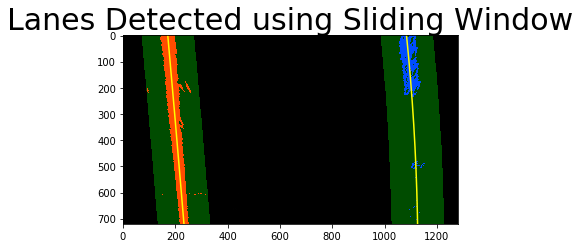

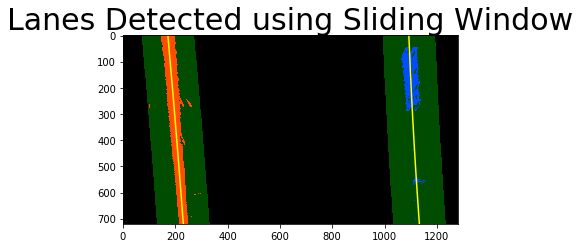

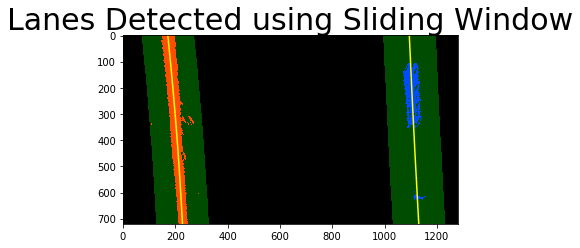

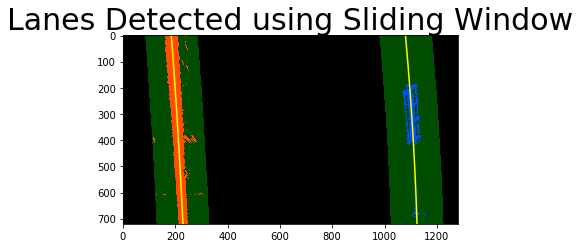

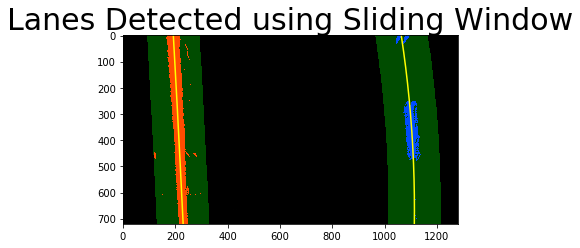

In [89]:
#left.iteration=0
    
video_output = '../output_Videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4").subclip(1,3.5)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)
  

In [81]:
attrs = vars(left)
# {'kids': 0, 'name': 'Dog', 'color': 'Spotted', 'age': 10, 'legs': 2, 'smell': 'Alot'}
# now dump this in some way or another
print(',\n '.join("%s: %s" % item for item in attrs.items()))

detected: False,
 current_fit: [array([False])],
 recent_xfitted: deque([array([-1.37464194e-05, -2.59710901e-02,  2.68038329e+02]), array([-4.49767015e-05,  8.24090864e-03,  2.61190395e+02]), array([-3.21056192e-05,  1.71951859e-03,  2.59913662e+02]), array([-2.20296961e-05,  1.65521522e-03,  2.55502153e+02]), array([-3.46850212e-05,  9.77804376e-03,  2.56669209e+02])], maxlen=5),
 radius_of_curvature: None,
 bestx: None,
 best_fit: None,
 line_base_pos: None,
 diffs: [0. 0. 0.],
 allx: None,
 ally: None,
 iteration: 364


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))